## Mitochondria Segmentation with a simple U-Net

#### Imports

In [1]:
import simple_model
import os
import cv2
import pandas as pd
from skimage import io
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from private_path import train_image_path, train_mask_path, test_image_path, test_mask_path
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from loses_and_metrics import dice_coefficient, dice_coefficients_loss, iou
from utils import createImageSegmentationGenerator


#### Load data

In [2]:
train_images = io.imread(train_image_path)
train_masks = io.imread(train_mask_path)
test_images = io.imread(test_image_path)
test_masks = io.imread(test_mask_path)
print(f'Train Image Shape: {train_images.shape}')
print(f'Train mask Shape: {train_masks.shape}')
print(f'Test images Shape: {test_images.shape}')
print(f'Test mask Shape: {test_masks.shape}')

Train Image Shape: (165, 768, 1024)
Train mask Shape: (165, 768, 1024)
Test images Shape: (165, 768, 1024)
Test mask Shape: (165, 768, 1024)


#### Resize and reshape dimensions for training/testing

In [12]:
# Data preprocessing 
SIZE = 256
# Reshape train images and convert to numpy array
X_train = []
for image in train_images:
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        X_train.append(image)
# Reshape train masks and convert to numpy array
y_train = []
for mask in train_masks:
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask = np.array(mask)
        y_train.append(mask)
# Refactor 100 test images/masks to train images/masks to have 280 - 50 train-test-split
X_test = []
for image in test_images:
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        X_test.append(image)
y_test = []
for mask in test_masks:
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask = np.array(mask)
        y_test.append(mask)
# Append to train images in masks
for image in X_test[:115]:
        X_train.append(image)
for mask in y_test[:115]:
        y_train.append(mask)
# New test images and masks
X_test = X_test[115:]
y_test = y_test[115:]

# Normalize images and expand dims
X_train = np.expand_dims(np.array(X_train), 3) 
X_test = np.expand_dims(np.array(X_test), 3)
# Rescale masks from 0 to 1 and expand dims
y_train = np.expand_dims((np.array(y_train)),3) 
y_test = np.expand_dims((np.array(y_test)),3) 

print(f'Train Image Shape: {X_train.shape}')
print(f'Train mask Shape: {y_train.shape}')
print(f'Test images Shape: {X_test.shape}')
print(f'Test mask Shape: {y_test.shape}')


Train Image Shape: (280, 256, 256, 1)
Train mask Shape: (280, 256, 256, 1)
Test images Shape: (50, 256, 256, 1)
Test mask Shape: (50, 256, 256, 1)


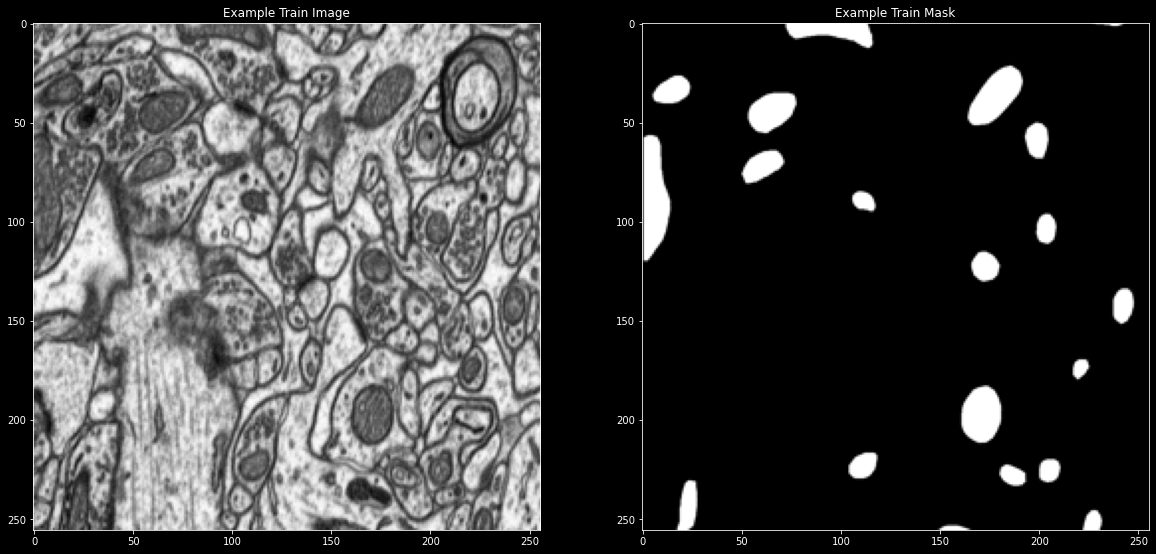

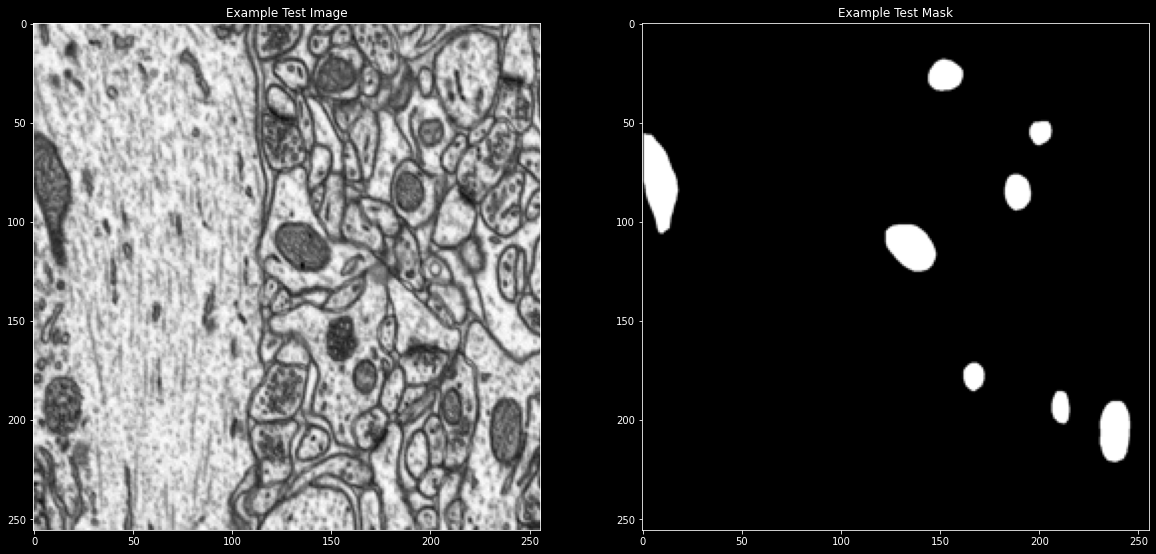

In [18]:
# Sanity check 
plt.figure(figsize=(20,15))
plt.axis('off')
plt.subplot(121)
plt.title('Example Train Image')
plt.imshow(X_train[200], cmap='gray')
plt.subplot(122)
plt.title('Example Train Mask')
plt.imshow(y_train[200], cmap='gray')
# Sanity check 
plt.figure(figsize=(20,15))
plt.axis('off')
plt.subplot(121)
plt.title('Example Test Image')
plt.imshow(X_test[40], cmap='gray')
plt.subplot(122)
plt.title('Example Test Mask')
plt.imshow(y_test[40], cmap='gray')


#### Create Train- and Test Generators 

In [ ]:
# Hyperparameters
BATCH_SIZE = 5
EPOCHS = 20
learning_rate = 1e-4
decay_rate = learning_rate/EPOCHS
steps_per_epoch = len(test_images) / BATCH_SIZE
# define data augmentation dict
augmentation_params = dict(
                              rotation_range=0.2,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              shear_range=0.05,
                              zoom_range=0.05,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )
# Create image generators with augmentation 
train_gen = createImageSegmentationGenerator(X_train, y_train, augmentation_dict=augmentation_params, batch_size=BATCH_SIZE)
test_gen = createImageSegmentationGenerator(X_test, y_test, augmentation_dict=augmentation_params, batch_size=BATCH_SIZE)

#### Load and Train Model

In [ ]:
# Load model with input size 256x256x1 color channels for grayscale
model = simple_model.Unet(input_size=(SIZE,SIZE,1))
# Load optimizer 
optimizer = Adam(learning_rate=learning_rate, amsgrad=False)
# Compile Model
model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=['binary_accuracy', iou, dice_coefficient])
# Defince training callback
callback = [ModelCheckpoint('mitochondriaSegmentationUNet.hdf5', verbose=1, save_best_only=True)]

In [ ]:
# Start training! - slow in ipynb :'|  
history = model.fit(
                train_gen,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                steps_per_epoch=steps_per_epoch,
                callbacks=callback,
                validation_data=test_gen,
                validation_steps=len(X_test)/ BATCH_SIZE
                )